## POS tagging using modified Viterbi

### 1. Data Preparation

In [209]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [211]:
# Dowloading "Treebank corpus"
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\PINAKI\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [212]:
# Dowloading "universal_tagset"
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\PINAKI\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [213]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PINAKI\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [214]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [215]:
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [216]:
# Splitting into train and test(95%-5%)
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))

3718
196


In [217]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95493

In [218]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Each',
 'new',
 'trading',
 'roadblock',
 'is',
 'likely',
 '*-1',
 'to',
 'be',
 'beaten']

In [219]:
# vocabulary
V = set(tokens)
print(len(V))

12047


In [220]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [221]:
# Printing Tags
print(T)

{'ADJ', 'CONJ', 'PRT', 'PRON', 'ADP', 'NOUN', 'NUM', 'VERB', '.', 'X', 'DET', 'ADV'}


##### Uploading test instances

In [224]:
# Reading the Test Sentences txt
text_file = open(r"C:\Users\PINAKI\Desktop\upgrad\NLP\Assignment\Sample test sentences.txt", "r")
lines = text_file.read()

In [226]:
# Tokenizing the sentences
test_instances = word_tokenize(lines)
test_instances

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

### 2. Build the vanilla Viterbi based POS tagger

##### 2.1 Emission Probability

In [227]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [228]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

##### 2.2 Transition Probability

In [229]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [230]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [231]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head(5)

,ADJ,CONJ,PRT,PRON,ADP,NOUN,NUM,VERB,.,X,DET,ADV
ADJ,0.066172,0.017162,0.010891,0.000495,0.077888,0.698680,0.021287,0.012046,0.065017,0.020792,0.004950,0.004620
CONJ,0.117729,0.000465,0.004653,0.059097,0.054444,0.348534,0.041880,0.155886,0.035365,0.007911,0.119591,0.054444
PRT,0.084735,0.001978,0.001319,0.017804,0.020442,0.249918,0.059017,0.400923,0.043192,0.012529,0.098582,0.009561
PRON,0.071787,0.004631,0.012736,0.008105,0.023157,0.212659,0.007719,0.485141,0.040525,0.092628,0.008491,0.032420
ADP,0.106346,0.000965,0.001501,0.068932,0.016938,0.321184,0.063465,0.008469,0.039987,0.035377,0.323113,0.013722


###### 2.3 Viterbi POS Algo

In [232]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

##### 2.4 Executing Viterbi POS tagging to Validation Set

In [234]:
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [235]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [236]:
# time of execution
difference

2357.430577278137

##### 2.5 Evaluating Viterbi Model accuracy

In [237]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
accuracy

0.9100906810727378

In [238]:
# Words tagged incorrectly
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('trained', 'VERB'), (('bellringers', 'ADJ'), ('bellringers', 'NOUN'))],
 [('only', 'ADV'), (('40,000', 'ADJ'), ('40,000', 'NUM'))],
 [('they', 'PRON'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('banks', 'NOUN'), (('pine', 'ADJ'), ('pine', 'VERB'))],
 [('pine', 'VERB'), (('for', 'ADP'), ('for', 'PRT'))],
 [('give', 'VERB'), (('much', 'ADV'), ('much', 'ADJ'))],
 [('much', 'ADJ'), (('thought', 'VERB'), ('thought', 'NOUN'))],
 [("n't", 'ADV'), (('forgotten', 'ADJ'), ('forgotten', 'VERB'))],
 [('the', 'DET'), (('leap', 'ADJ'), ('leap', 'NOUN'))],
 [('first', 'ADJ'), (('bout', 'ADJ'), ('bout', 'NOUN'))],
 [('stocks', 'NOUN'), (('skyward', 'ADJ'), ('skyward', 'ADV'))],
 [('last', 'ADJ'), (('half-hour', 'NOUN'), ('half-hour', 'ADJ'))],
 [('who', 'PRON'), (('*T*-254', 'ADJ'), ('*T*-254', 'X'))],
 [('written', 'VERB'), (('enough', 'ADV'), ('enough', 'ADJ'))],
 [('prevent', 'VERB'), (('such', 'ADJ'), ('such', 'DET'))],
 [('hero', 'NOUN'), (('sets', 'NOUN'), ('sets', 'VERB'))],
 [('for', 'ADP'), (

In [239]:
## Executing in Test Sentences
start = time.time()
tagged_seq_test = Viterbi(test_instances)
end = time.time()
difference_test = end-start
difference_test

78.40399694442749

In [240]:
print(tagged_seq_test)

[('Android', 'ADJ'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADJ'), ('.', '.'), ('Android', 'ADJ'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADJ'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'ADJ'), ('since', 'ADP'), ('2011', 'ADJ'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADJ'), ('.', '.'), ('Google', 'ADJ'), ('and', 'CONJ'), ('Twitter', 'ADJ'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADJ'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'ADJ'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADJ'), ("'s", 'PRT'), ('firehose', 'ADJ'), ('.', '.'), ('Twitter', 'ADJ'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADJ'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOU

### 3. Viterbi Modifications

1. To increase the efficiency of the Viterbi Model, we need to handle the unknown words which are not present in the training corpus.
2. For these unknown words `emission probabability` = 0, hence `state probability` = 0 as well

##### 3.1 - Method 1 (Tagging unknown words)

As we have observed the `emission probability` = 0 for 'unknown words', tagging those words as per the maximum `transistion probability`.

In [241]:
# Viterbi Heuristic
def Viterbi_mod(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        tp = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            tp.append(transition_p)
            p.append(state_probability)
                
        if max(p)==0:
            pmax = max(tp)
            state_max = T[tp.index(pmax)] 
        else:
            pmax = max(p)
            state_max = T[p.index(pmax)] 
        
        # getting state for which probability is maximum     
        state.append(state_max)
        
    return list(zip(words, state))

In [242]:
# tagging the test sentences Mod 1
start = time.time()
tagged_seq1 = Viterbi_mod(test_tagged_words)
end = time.time()
difference1 = end-start

In [243]:
# time of execution Mod1
difference1

2196.8854429721832

##### 3.1.2 Evaluating accuracy of model 1

In [248]:
# accuracy Mod 1
check = [i for i, j in zip(tagged_seq1, test_run_base) if i == j] 
accuracy1 = len(check)/len(tagged_seq1)
accuracy1

0.9289986494308315

In [291]:
# Words tagged incorrectly Mod 1
incorrect_tagged_cases1 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq1, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases1

[[('trained', 'VERB'), (('bellringers', 'X'), ('bellringers', 'NOUN'))],
 [('only', 'ADV'), (('40,000', 'VERB'), ('40,000', 'NUM'))],
 [('they', 'PRON'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('A', 'DET'), (('high-balance', 'NOUN'), ('high-balance', 'ADJ'))],
 [('banks', 'NOUN'), (('pine', 'NOUN'), ('pine', 'VERB'))],
 [('pine', 'VERB'), (('for', 'ADP'), ('for', 'PRT'))],
 [('give', 'VERB'), (('much', 'ADV'), ('much', 'ADJ'))],
 [('much', 'ADJ'), (('thought', 'VERB'), ('thought', 'NOUN'))],
 [('of', 'ADP'), (('foreign-led', 'DET'), ('foreign-led', 'ADJ'))],
 [('stocks', 'NOUN'), (('skyward', 'NOUN'), ('skyward', 'ADV'))],
 [('last', 'ADJ'), (('half-hour', 'NOUN'), ('half-hour', 'ADJ'))],
 [('who', 'PRON'), (('*T*-254', 'VERB'), ('*T*-254', 'X'))],
 [('written', 'VERB'), (('enough', 'ADV'), ('enough', 'ADJ'))],
 [('prevent', 'VERB'), (('such', 'ADJ'), ('such', 'DET'))],
 [('A', 'DET'), (('disaffected', 'NOUN'), ('disaffected', 'ADJ'))],
 [(',', '.'), (('hard-drinking', 'NOUN'), ('hard-d

In [249]:
## Testing
start = time.time()
tagged_seq_test1 = Viterbi_mod(test_instances)
end = time.time()
difference_test1 = end-start
print(tagged_seq_test1)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('user

##### 3.2 Method 2 (Rule Bases Tagging)

- For the words for which `emission_probability = 0`, implementing a Lexicon based tagger

In [250]:
# importing RegEx library
import re

In [251]:
# Modified Viterbi Heuristic
def Viterbi_mod2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = []
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p
            p.append(state_probability)
                
        if max(p)==0:
            
            if re.search(r'.*ing$', words[key]):
                state_max = 'VERB'
            elif re.search(r'.*ed$', words[key]):
                state_max = 'VERB'
            elif re.search(r'.*es$', words[key]):
                state_max = 'VERB'
            elif re.search(r'.*ould$', words[key]):
                state_max = 'VERB'
            elif re.search(r'^-?[0-9]+(.[0-9]+)?$', words[key]):
                state_max = 'NUM'
            elif re.search(r'.*able$', words[key]):
                state_max = 'ADJ'                   
            elif re.search(r'.*ness$', words[key]):
                state_max = 'NOUN'
            elif re.search(r'.*ly$', words[key]):
                state_max = 'NOUN'
            elif re.search(r'.*\'s$', words[key]):
                state_max = 'NOUN'
            elif re.search(r'.*s$', words[key]):
                state_max = 'NOUN'
            elif re.search(r'.*', words[key]):
                state_max = 'NOUN'
            

        else:
            pmax = max(p)
            state_max = T[p.index(pmax)] 
        
        # getting state for which probability is maximum     
        state.append(state_max)          .
    return list(zip(words, state))

In [254]:
# tagging the test sentences Mod 2
start = time.time()
tagged_seq2 = Viterbi_mod2(test_tagged_words)
end = time.time()
difference2 = end-start

In [268]:
# time of execution Mod 2
difference2

2299.583652973175

##### 3.2.2 Evaluating tagging accuracy- Model 2

In [257]:
# accuracy for modified Viterbi (2)
check = [i for i, j in zip(tagged_seq2, test_run_base) if i == j] 
accuracy2 = len(check)/len(tagged_seq2)
accuracy2

0.9425043411151842

In [292]:
# Words tagged incorrectly for modified Viterbi (2)
incorrect_tagged_cases2 = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq2, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases2

[[('they', 'PRON'), (('own', 'ADJ'), ('own', 'VERB'))],
 [('A', 'DET'), (('high-balance', 'NOUN'), ('high-balance', 'ADJ'))],
 [('banks', 'NOUN'), (('pine', 'NOUN'), ('pine', 'VERB'))],
 [('pine', 'VERB'), (('for', 'ADP'), ('for', 'PRT'))],
 [('give', 'VERB'), (('much', 'ADV'), ('much', 'ADJ'))],
 [('much', 'ADJ'), (('thought', 'VERB'), ('thought', 'NOUN'))],
 [("n't", 'ADV'), (('forgotten', 'NOUN'), ('forgotten', 'VERB'))],
 [('of', 'ADP'), (('foreign-led', 'VERB'), ('foreign-led', 'ADJ'))],
 [('stocks', 'NOUN'), (('skyward', 'NOUN'), ('skyward', 'ADV'))],
 [('last', 'ADJ'), (('half-hour', 'NOUN'), ('half-hour', 'ADJ'))],
 [('who', 'PRON'), (('*T*-254', 'NOUN'), ('*T*-254', 'X'))],
 [('written', 'VERB'), (('enough', 'ADV'), ('enough', 'ADJ'))],
 [('prevent', 'VERB'), (('such', 'ADJ'), ('such', 'DET'))],
 [('A', 'DET'), (('disaffected', 'VERB'), ('disaffected', 'ADJ'))],
 [(',', '.'), (('hard-drinking', 'VERB'), ('hard-drinking', 'ADJ'))],
 [(',', '.'), (('nearly-30', 'NOUN'), ('nearly

In [259]:
## Testing
start = time.time()
tagged_seq_test2 = Viterbi_mod2(test_instances)
end = time.time()
difference_test2 = end-start
print(tagged_seq_test2)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), (

### 4. Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [265]:
# accuracy & run time in Viterbi Model
print("Accuracy of classic Viterbi Model = ", accuracy, "| Execution time is = ", difference)

Accuracy of classic Viterbi Model =  0.9100906810727378 | Execution time is =  2357.430577278137


In [269]:
# accuracy & run time in Modified Viterbi Model(1)
print("Accuracy of Modified Viterbi Model (1) = ", accuracy1, "| Execution time is = ", difference1)

Accuracy of Modified Viterbi Model (1) =  0.9289986494308315 | Execution time is =  2196.8854429721832


- As observed, the accuracy icreased approximately `20%` in the modified Viterbi Model(1)

In [270]:
# accuracy & run time in Modified Viterbi Model(2)
print("Accuracy of Modified Viterbi Model (2) = ", accuracy2, "| Execution time is = ", difference2)

Accuracy of Modified Viterbi Model (2) =  0.9425043411151842 | Execution time is =  2299.583652973175


- As observed, the accracy icreased more than `30%` in the modified Viterbi Model(2)

<BarContainer object of 3 artists>

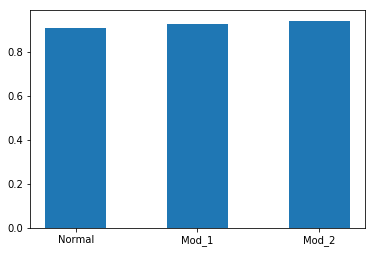

In [286]:
# Bar plots for accuracies
acc = [accuracy, accuracy1, accuracy2]
mod = ['Normal', 'Mod_1', 'Mod_2']
plt.bar(mod, acc, width=0.5, bottom=None, align='center', data=None)

### 5. List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [293]:
# Incorrectly tagged words in all the variations
print("Number of words tagged incorrectly in Classic Viterbi = ",len(incorrect_tagged_cases))
print("Number of words tagged incorrectly in Modified Viterbi(1) = ",len(incorrect_tagged_cases1))
print("Number of words tagged incorrectly in Modified Viterbi(2) = ",len(incorrect_tagged_cases2))

Number of words tagged incorrectly in Classic Viterbi =  466
Number of words tagged incorrectly in Modified Viterbi(1) =  368
Number of words tagged incorrectly in Modified Viterbi(2) =  298


<BarContainer object of 3 artists>

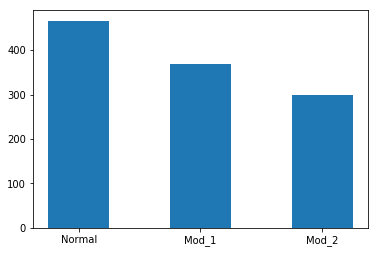

In [296]:
# Bar plots for wrongly tagged cases
wtags = [len(incorrect_tagged_cases), len(incorrect_tagged_cases1), len(incorrect_tagged_cases2)]
mod = ['Normal', 'Mod_1', 'Mod_2']
plt.bar(mod, wtags, width=0.5, bottom=None, align='center', data=None)

In [305]:
# list of incorrectly tagged words original Viterbi
wordlist = [tup[0][0] for tup in incorrect_tagged_cases]
wordlist[:5]

['trained', 'only', 'they', 'banks', 'pine']

In [307]:
# list of incorrectly tagged words modified Viterbi 1
wordlist1 = [tup[0][0] for tup in incorrect_tagged_cases1]
wordlist1[:5]

['trained', 'only', 'they', 'A', 'banks']

In [308]:
# list of incorrectly tagged words modified Viterbi 2
wordlist2 = [tup[0][0] for tup in incorrect_tagged_cases2]
wordlist2[:5]

['they', 'A', 'banks', 'pine', 'give']

In [321]:
# words corrected in modified viterbi 1
correctword =list(set(wordlist).difference(set(wordlist1)))
correctword[:10]

['revenue-desperate',
 'expendable',
 'Cruise',
 'gambling',
 'theological',
 'almost',
 'illegal',
 'Kent',
 'school',
 'Video']

In [324]:
# words corrected in modified viterbi mod 1
correctword1 =list(set(wordlist).difference(set(wordlist2)))
correctword1[:10]

['granting',
 'expendable',
 'gambling',
 'almost',
 'sell',
 'becomes',
 'illegal',
 'are',
 'Kent',
 'school']

- We can observe from the lists above, the words which are tagged properly in the modifications of original Viterbi Algorithm.


##### Let's observe how the models behave to some samples 

- Comparing Original Viterbi with first modificarion

In [345]:
# finding tags for a sample- Original Viterbi
test_seq = Viterbi(correctword[38:43])
test_seq

[('Elisa', 'ADJ'),
 ('certified', 'ADJ'),
 ('Nicole', 'ADJ'),
 ('Gary', 'NOUN'),
 ('circuit', 'NOUN')]

In [346]:
# finding tags for a sample- Modified Viterbi(1)
test_seq1 = Viterbi_mod(correctword[38:43])
test_seq1

[('Elisa', 'NOUN'),
 ('certified', 'NOUN'),
 ('Nicole', 'NOUN'),
 ('Gary', 'NOUN'),
 ('circuit', 'NOUN')]

- Unknown names such as 'Elisa', 'Nicole' etc were wrongly tagged as 'ADJ', which were correctly tagged as 'NOUN' in the 1st modification.

- Comparing Original Viterbi with second modificarion

In [332]:
# finding tags for a sample- Original Viterbi
test_seq2 = Viterbi(correctword1[:5])
test_seq2

[('granting', 'ADJ'),
 ('expendable', 'ADJ'),
 ('gambling', 'ADJ'),
 ('almost', 'ADV'),
 ('sell', 'VERB')]

In [333]:
# finding tags for a sample- Modified Viterbi(2)
test_seq3 = Viterbi_mod2(correctword1[:5])
test_seq3

[('granting', 'VERB'),
 ('expendable', 'ADJ'),
 ('gambling', 'VERB'),
 ('almost', 'ADV'),
 ('sell', 'VERB')]

- Words such as 'granting', 'gambling' were wrongly tagged as 'ADJ', which were correctly tagged as 'VERB' in the 2nd modification.